# Predicting stock market behavior from text:

**Description:**

The goal of this project is to develop an NLP model capable of predicting the Market sentiment based on text.

In summary, with the NLP techniques you have learned during class, you must implement a classifier that receives text as inputs and is able to predict, for each tweet, if it describes a Bearish (0), Bullish (1), or Neutral (2) attitude.

## 1. Data Import

In [79]:
import collections
import gensim.downloader
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import string
from collections import Counter
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from tqdm import tqdm
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Loading the dataset and visualizing summary statistics
market_behavior_df_train = pd.read_csv('/Users/riccardogurzu/Desktop/Project Data(1)/train.csv')
market_behavior_df_test = pd.read_csv('/Users/riccardogurzu/Desktop/Project Data(1)/test.csv', index_col='id')

## 2. Data Exploration

In [ ]:
market_behavior_df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [ ]:
market_behavior_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


### 2.1. Label (Dependent feature)

In [ ]:
# Get summary statistics for the 'label' column
label_stats = market_behavior_df_train['label'].describe()

# Print the summary statistics
print('Summary Statistics for the "label" Column:\n')
print(label_stats)

Summary Statistics for the "label" Column:

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64


In [ ]:
#check if there are any null values
market_behavior_df_train['label'].isna().sum()

0

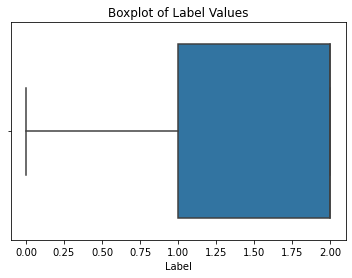

In [ ]:
# Create a boxplot of the 'label' column
sns.boxplot(x=market_behavior_df_train['label'])
plt.title('Boxplot of Label Values')
plt.xlabel('Label')
plt.show()

In [ ]:
# Get unique values in the 'label' column
unique_labels = market_behavior_df_train['label'].unique()

# Print the unique label values
print('\nUnique Label Values:')
print(unique_labels)


Unique Label Values:
[0 1 2]


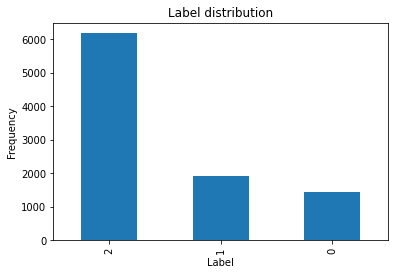

In [ ]:
# Plot a bar chart of the label distribution
market_behavior_df_train['label'].value_counts().plot(kind='bar')
plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

### 2.2. Text (Independent features)

In [ ]:
market_behavior_df_train['text'].isna().sum()

0

In [ ]:
# Fetch wordcount for each abstract
market_behavior_df_train['word_count']  = market_behavior_df_train['text'].apply(lambda x: len(str(x).split(" ")))
market_behavior_df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [ ]:
market_behavior_df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

In [ ]:
# Print some basic statistics about the data
print("Number of text: ", len(market_behavior_df_train))
print("Number of bearish text: ", len(market_behavior_df_train[market_behavior_df_train['label'] == 0]))
print("Number of bullish text: ", len(market_behavior_df_train[market_behavior_df_train['label'] == 1]))
print("Number of neutral text: ", len(market_behavior_df_train[market_behavior_df_train['label'] == 2]))

Number of text:  9543
Number of bearish text:  1442
Number of bullish text:  1923
Number of neutral text:  6178


In [ ]:
# Get summary statistics for the 'text length' column
market_behavior_df_train['text_length'] = market_behavior_df_train['text'].apply(lambda x: len(x.split()))

# Print the summary statistics
print('Summary Statistics for the "text_length" Column:\n')
print(market_behavior_df_train['text_length'].describe())

Summary Statistics for the "text_length" Column:

count    9543.000000
mean       12.178351
std         4.665599
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        32.000000
Name: text_length, dtype: float64


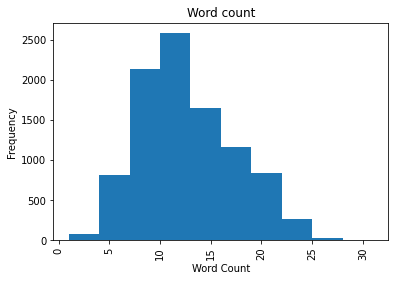

In [ ]:
# Create a bar chart of the word count
plt.hist(market_behavior_df_train['word_count'])
plt.title('Word count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Concatenate all the text into a single string
all_text = ' '.join(market_behavior_df_train['text'])

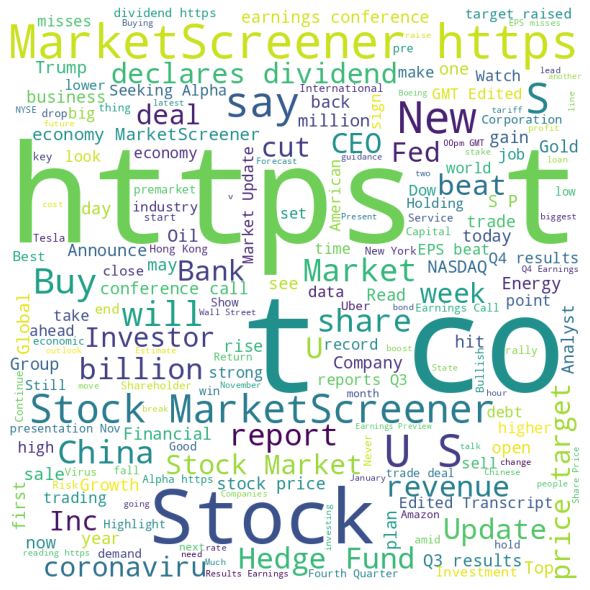

In [ ]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=200).generate(all_text)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

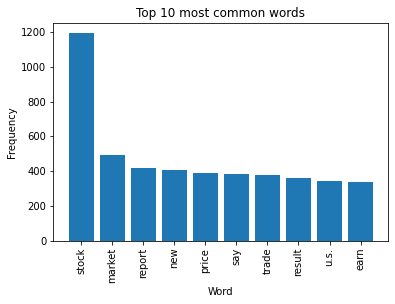

In [ ]:
# Combine all text into a single string
all_text = ' '.join(market_behavior_df_train['text'])
#lower case all words
all_text = all_text.lower()  
#removed # from all words
all_text = all_text.replace("#", "")

# Tokenize the string (split it into individual words)
words = all_text.split()

# Remove stop words and punctuation from the list of words
stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)
words = [word for word in words if word not in stop_words and word not in exclude]

#Stemming
stemmer = SnowballStemmer('english')
words = [stemmer.stem(word) for word in words]

# Count the frequency of each word
word_counts = Counter(words)

# Get the 10 most common words
top_words = word_counts.most_common(10)

# Create a bar chart of the top words
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.title('Top 10 most common words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

<ipython-input-101-b8768565240e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([word[0] for word in top_words], rotation=90)


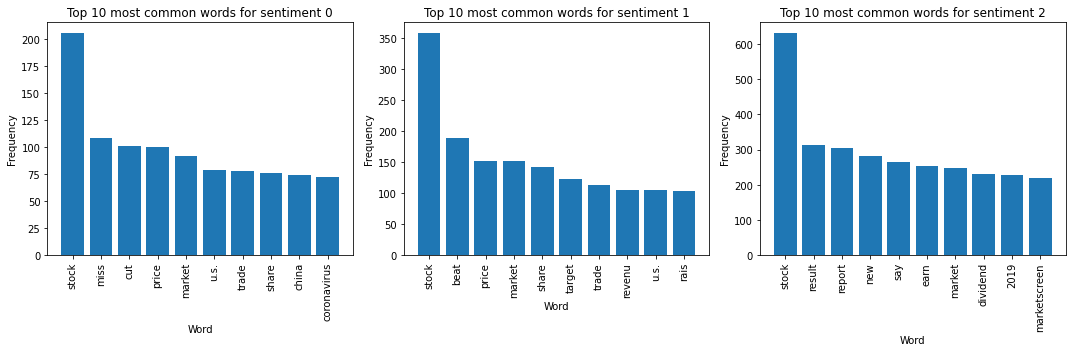

In [ ]:
# Create a list of unique sentiments in the dataframe
unique_sentiments = market_behavior_df_train['label'].unique()

# Create a figure with 3 columns and 1 row
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over each sentiment and plot a histogram in a separate subplot
for i, sentiment in enumerate(unique_sentiments):
    # Combine all text for this sentiment into a single string
    sentiment_text = ' '.join(market_behavior_df_train[market_behavior_df_train['label'] == sentiment]['text'])
    sentiment_text = sentiment_text.lower()
    sentiment_text = sentiment_text.replace("#", "")

    # Tokenize the string (split it into individual words)
    words = sentiment_text.split()

    # Remove stop words and punctuation from the list of words
    words = [word for word in words if word not in stop_words and word not in exclude]

    #Stemming
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    # Count the frequency of each word
    word_counts = Counter(words)

    # Get the 10 most common words
    top_words = word_counts.most_common(10)

    # Plot a bar chart of the top words for this sentiment in the corresponding subplot
    axs[i].bar([word[0] for word in top_words], [word[1] for word in top_words])
    axs[i].set_xticklabels([word[0] for word in top_words], rotation=90)
    axs[i].set_title(f'Top 10 most common words for sentiment {sentiment}')
    axs[i].set_xlabel('Word')
    axs[i].set_ylabel('Frequency')

# Adjust the layout and spacing of the subplots
plt.tight_layout()

# Show the figure
plt.show()

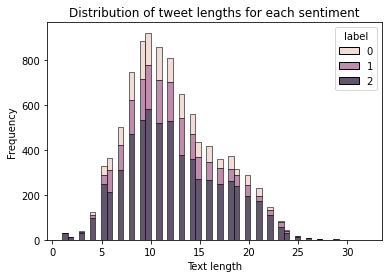

In [ ]:
# Create a histogram of tweet lengths for each sentiment
sns.histplot(data=market_behavior_df_train, x='text_length', hue='label', multiple='stack')
plt.title('Distribution of tweet lengths for each sentiment')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

## 3. Utility Functions

### 3.1. Data preprocessing

In [8]:
lemma = WordNetLemmatizer()

In [9]:
stemmer = SnowballStemmer('english')

In [12]:
stop_words = set(stopwords.words("english"))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        # Remove URLs
        text = re.sub(r"http\S+", "", text) 

        # Remove mentions
        text = re.sub(r"@\S+", "", text) 
        
        # Remove hashtags
        text = re.sub(r"#\S+", "", text)

        #Lowercase text
        text = text.lower()
        
        #Remove numerical data and punctuation
        text = re.sub("[^a-zA-Z]"," ", text)
        text = re.sub("br", "", text)
        
        #Tokenize text
        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(text)
        
        #POS filtering for nouns and adjectives
        filtered_tokens = [word for word, pos in pos_tag(tokens) if pos.startswith('NN') or pos.startswith('JJ')]
        
        #Remove stopwords
        filtered_tokens = [word for word in filtered_tokens if word not in stop_words]
        
        #Lemmatize
        if lemmatize:
            filtered_tokens = [lemma.lemmatize(word) for word in filtered_tokens]
        
        #Stemming
        if stemmer:
            filtered_tokens = [stemmer.stem(word) for word in filtered_tokens]
            
        text = " ".join(filtered_tokens)
        
        updates.append(text)
        
    return updates

### 3.2. Evaluation

In [13]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

## 4. Comparison of Feature Engineering Techniques for Text Classification

In [ ]:
'''
#the choice of the parameters was made consdering the results of a hyperparameter tuning using GridSearchCV() for each classifier build as follow:


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Define pipeline
pipe = Pipeline([('vectorizer', CountVectorizer()), ('classifier', LogisticRegression())])

# Set hyperparameters to search over
params = [{'vectorizer': [CountVectorizer(), TfidfVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [LinearSVC()],
        'classifier__multi_class': ['ovr', 'crammer_singer'],
        'classifier__loss': ['hinge', 'squared_hinge'],
        'classifier__C': [0.1, 1.0, 10.0]}]

# Perform GridSearchCV
grid_lsvc = GridSearchCV(pipe, params, cv=5)
grid_lsvc.fit(X_train, y_train)

# Print best estimator and its score on the test data
print(f"Best estimator:\n{grid_lsvc.best_estimator_}")
print(f"Test score: {grid_lsvc.score(X_val, y_val)}")
y_pred = grid_lsvc.predict(X_val)
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_val, y_pred, target_names = labels.keys()))


#for lack of computational power and time (some classifiers took couple of hourse to run), in the following code we just considered the parameters obteined 
'''

### 4.1. Bag of Words (Bow)

In [54]:
# Define feature
X = market_behavior_df_train["text"]

# Define target
y = np.array(market_behavior_df_train['label'])

In [36]:
# Define the vector
bow = CountVectorizer(binary=True)

In [37]:
# Define the number of folds for cross-validation
n_splits = 5

# Create the models
model_knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')
model_lr = LogisticRegression()
model_mlp = MLPClassifier(hidden_layer_sizes=(10, 10))
model_nb = GaussianNB()

# Create a KFold object to split the data into folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a list for each model's score
score_knn_list = []
score_lr_list = []
score_mlp_list = []
score_nb_list = []

# Initialize counter variable
fold_num = 0

# Iterate over the folds
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Preprocess the training data
    X_train_clean = clean(X_train, lemmatize = True, stemmer = False)

    # Preprocess the validation data using the same steps as the training data
    X_val_clean = clean(X_val, lemmatize = True, stemmer = False)

    # Vectorize both training and validation data using the vocabulary learned from the training set
    X_train_vectorize = bow.fit_transform(X_train_clean)
    X_val_vectorize = bow.transform(X_val_clean)

    # Fit the KNN model using the training data
    model_knn.fit(X_train_vectorize, y_train)

    # Evaluate the KNN model using the validation data
    score_knn = model_knn.score(X_val_vectorize, y_val)
    score_knn_array = np.array(score_knn).reshape(1,)

    # Fit the LR model using the training data
    model_lr.fit(X_train_vectorize, y_train)

    # Evaluate the LR model using the validation data
    score_lr = model_lr.score(X_val_vectorize, y_val)
    score_lr_array = np.array(score_lr).reshape(1,)

    # Fit the MLP model using the training data
    model_mlp.fit(X_train_vectorize, y_train)

    # Evaluate the MLP model using the validation data
    score_mlp = model_mlp.score(X_val_vectorize, y_val)
    score_mlp_array = np.array(score_mlp).reshape(1,)

    # Fit the NB model using the training data
    X_train_array = X_train_vectorize.toarray()
    model_nb.fit(X_train_array, y_train)

    # Evaluate the NB model using the validation data
    X_val_array = X_val_vectorize.toarray()
    score_nb = model_nb.score(X_val_array, y_val)
    score_nb_array = np.array(score_nb).reshape(1,)

    fold_num += 1

    # Print the scores for this fold
    print(f"\n Fold {fold_num} - KNN Score: {score_knn}, LR Score: {score_lr}, MLP Score: {score_mlp}, NB Score: {score_nb}")

    score_knn_list.append(score_knn_array)
    score_lr_list.append(score_lr_array)
    score_mlp_list.append(score_mlp_array)
    score_nb_list.append(score_nb_array)

100%|██████████| 1909/1909 [00:00<00:00, 3257.85it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 1 - KNN Score: 0.7338920900995285, LR Score: 0.7537977998952331, MLP Score: 0.6966998428496595, NB Score: 0.5437401781037192


100%|██████████| 1909/1909 [00:00<00:00, 3254.06it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 2 - KNN Score: 0.7422734415924568, LR Score: 0.7585123101100052, MLP Score: 0.6841278156102671, NB Score: 0.5479308538501834


100%|██████████| 1909/1909 [00:00<00:00, 3273.07it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 3 - KNN Score: 0.7312729177579885, LR Score: 0.7595599790466213, MLP Score: 0.6752226296490309, NB Score: 0.5149292823467784


100%|██████████| 1908/1908 [00:00<00:00, 3332.03it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 4 - KNN Score: 0.7332285115303984, LR Score: 0.7468553459119497, MLP Score: 0.6677148846960168, NB Score: 0.5120545073375262


100%|██████████| 1908/1908 [00:00<00:00, 3225.09it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Fold 5 - KNN Score: 0.7206498951781971, LR Score: 0.7547169811320755, MLP Score: 0.6823899371069182, NB Score: 0.5382599580712788


In [38]:
# Calculate the mean scores for each model
mean_score_knn_BoW = np.mean(np.concatenate(score_knn_list))
mean_score_lr_BoW = np.mean(np.concatenate(score_lr_list))
mean_score_mlp_BoW = np.mean(np.concatenate(score_mlp_list))
mean_score_nb_BoW = np.mean(np.concatenate(score_nb_list))

In [39]:
# Print the mean scores for each model
print(f"Mean KNN Score: {mean_score_knn_BoW}")
print(f"Mean LR Score: {mean_score_lr_BoW}")
print(f"Mean MLP Score: {mean_score_mlp_BoW}")
print(f"Mean NB Score: {mean_score_nb_BoW}")

# Determine the best model based on the mean score
best_model_BoW = max(mean_score_knn_BoW, mean_score_lr_BoW, mean_score_mlp_BoW, mean_score_nb_BoW)
if best_model_BoW == mean_score_knn_BoW:
    best_model_BoW = model_knn
elif best_model_BoW == mean_score_lr_BoW:
    best_model_BoW = model_lr
elif best_model_BoW == mean_score_mlp_BoW:
    best_model_BoW = model_mlp
else:
    best_model_BoW = model_nb

# Print the mean scores for each model
print(f"The best model is: {type(best_model_BoW).__name__}")

Mean KNN Score: 0.7322633712317139
Mean LR Score: 0.754688483219177
Mean MLP Score: 0.6812310219823784
Mean NB Score: 0.5313829559418972
The best model is: LogisticRegression


In [40]:
model_lr_BoW = model_lr

In [41]:
# Define the test sentences
test_sentences = ['Autodesk downgraded to underweight from neutral at JPMorgan.', "Terrible restaurant!"]

# Clean the test sentences
test_clean = clean(test_sentences, lemmatize=True, stemmer=False)

# Transform the test sentences into bag-of-words representation using the same vectorizer
test = bow.transform(test_clean)

# Make predictions using the best performing model based on cross-validation
predictions = best_model_BoW.predict(test)

# Print the predictions for each test sentence
for sentence, prediction in zip(test_sentences, predictions):
    print(f'\n The predicted sentiment for the sentence "{sentence}" is {prediction}.')

100%|██████████| 2/2 [00:00<00:00, 1113.73it/s]


 The predicted sentiment for the sentence "Autodesk downgraded to underweight from neutral at JPMorgan." is 0.

 The predicted sentiment for the sentence "Terrible restaurant!" is 2.


In [42]:
# Preprocess the validation data using the same steps as the training data
# In order to maintain simplicity and consistency, we will utilize the X_val data from the previous K-fold split.
X_val_clean = clean(X_val, lemmatize=True, stemmer=False)

# Vectorize the validation data using the vocabulary learned from the training set
X_val_vectorize = bow.transform(X_val_clean)

# Use the best model to make predictions on the validation set
y_pred = best_model_BoW.predict(X_val_vectorize)

100%|██████████| 1908/1908 [00:00<00:00, 3130.11it/s]


In [43]:
# Evaluate BoW
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.36      0.61      0.45       168
     Bullish       0.53      0.68      0.60       312
     Neutral       0.92      0.79      0.85      1428

    accuracy                           0.75      1908
   macro avg       0.60      0.69      0.63      1908
weighted avg       0.81      0.75      0.77      1908



In [ ]:
confusion_matrix(y_pred, y_val)

array([[ 103,   28,   37],
       [  41,  212,   59],
       [ 146,  157, 1125]])

<ipython-input-106-3dffcdc7d557>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


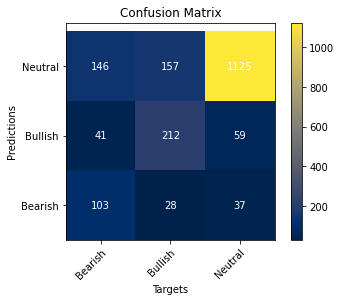

In [ ]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

### 4.2. Term Frequency - Inverse Document Frequency (TF-IDF)

In [74]:
# Define feature
X = market_behavior_df_train["text"]

# Define target
y = np.array(market_behavior_df_train['label'])

In [83]:
# Define the vector
tfidf = TfidfVectorizer(ngram_range=(1, 2))

Using bigrams can be helpful when the significance of a phrase or concept depends on word combinations rather than individual words. However, for our Text Mining project, since we are dealing with small amounts of data, including bigrams can increase the dimensionality of the vector space, which may not always be beneficial for small datasets. Moreover, it can result in overfitting and diminished performance on unseen data, as well as introduce irrelevant information or noise. As a result, we have chosen not to include the ngram_range=(1,2) parameter.

In [91]:
# Define the number of folds for cross-validation
n_splits = 5

# Create the models
model_knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')
model_lr = LogisticRegression()
model_mlp = MLPClassifier(hidden_layer_sizes=(10, 10))
model_nb = GaussianNB()
model_lsvc = LinearSVC(loss='hinge')

# Create a KFold object to split the data into folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a list for each model's score
score_knn_list = []
score_lr_list = []
score_mlp_list = []
score_nb_list = []
score_lsvc_list = []

# Initialize counter variable
fold_num = 0

# Iterate over the folds
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Preprocess the training data
    X_train_clean = clean(X_train, lemmatize = True, stemmer = False)

    # Preprocess the validation data using the same steps as the training data
    X_val_clean = clean(X_val, lemmatize = True, stemmer = False)

    # Vectorize both training and validation data using the vocabulary learned from the training set
    X_train_vectorize = tfidf.fit_transform(X_train_clean)
    X_val_vectorize = tfidf.transform(X_val_clean)

    # Fit the KNN model using the training data
    model_knn.fit(X_train_vectorize, y_train)

    # Evaluate the KNN model using the validation data
    score_knn = model_knn.score(X_val_vectorize, y_val)
    score_knn_array = np.array(score_knn).reshape(1,)

    # Fit the LR model using the training data
    model_lr.fit(X_train_vectorize, y_train)

    # Evaluate the LR model using the validation data
    score_lr = model_lr.score(X_val_vectorize, y_val)
    score_lr_array = np.array(score_lr).reshape(1,)

    # Fit the MLP model using the training data
    model_mlp.fit(X_train_vectorize, y_train)

    # Evaluate the MLP model using the validation data
    score_mlp = model_mlp.score(X_val_vectorize, y_val)
    score_mlp_array = np.array(score_mlp).reshape(1,)

    # Fit the NB model using the training data
    X_train_array = X_train_vectorize.toarray()
    model_nb.fit(X_train_array, y_train)

    # Evaluate the NB model using the validation data
    X_val_array = X_val_vectorize.toarray()
    score_nb = model_nb.score(X_val_array, y_val)
    score_nb_array = np.array(score_nb).reshape(1,)

    # Fit the MLP model using the training data
    model_lsvc.fit(X_train_vectorize, y_train)

    # Evaluate the MLP model using the validation data
    score_lsvc = model_lsvc.score(X_val_vectorize, y_val)
    score_lsvc_array = np.array(score_lsvc).reshape(1,)

    fold_num += 1

    # Print the scores for this fold
    print(f"\n Fold {fold_num} - KNN Score: {score_knn}, LR Score: {score_lr}, MLP Score: {score_mlp}, NP Score: {score_nb}, Linear SVC Score: {score_lsvc}")

    score_knn_list.append(score_knn_array)
    score_lr_list.append(score_lr_array)
    score_mlp_list.append(score_mlp_array)
    score_nb_list.append(score_nb_array)
    score_lsvc_list.append(score_lsvc_array)

100%|██████████| 1909/1909 [00:00<00:00, 3202.63it/s]



 Fold 1 - KNN Score: 0.7412257726558408, LR Score: 0.748559455212153, MLP Score: 0.7668936616029335, NP Score: 0.6458878994237821, Linear SVC: 0.7778941854374017


100%|██████████| 1909/1909 [00:00<00:00, 3260.54it/s]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 2 - KNN Score: 0.7454164484023049, LR Score: 0.7579884756416972, MLP Score: 0.7611314824515453, NP Score: 0.6558407543216344, Linear SVC: 0.7799895233106339


100%|██████████| 1909/1909 [00:00<00:00, 3244.82it/s]



 Fold 3 - KNN Score: 0.7281299109481404, LR Score: 0.7558931377684651, MLP Score: 0.7349397590361446, NP Score: 0.6291251964379256, Linear SVC: 0.7805133577789418


100%|██████████| 1908/1908 [00:00<00:00, 3265.27it/s]



 Fold 4 - KNN Score: 0.7258909853249476, LR Score: 0.7447589098532494, MLP Score: 0.7421383647798742, NP Score: 0.6221174004192872, Linear SVC: 0.7594339622641509


100%|██████████| 1908/1908 [00:00<00:00, 3244.58it/s]



 Fold 5 - KNN Score: 0.7243186582809225, LR Score: 0.739517819706499, MLP Score: 0.750524109014675, NP Score: 0.6346960167714885, Linear SVC: 0.769916142557652


In [92]:
# Calculate the mean scores for each model
mean_score_knn_TF_IDF = np.mean(np.concatenate(score_knn_list))
mean_score_lr_TF_IDF = np.mean(np.concatenate(score_lr_list))
mean_score_mlp_TF_IDF = np.mean(np.concatenate(score_mlp_list))
mean_score_nb_TF_IDF = np.mean(np.concatenate(score_nb_list))
mean_score_lsvc_TF_IDF = np.mean(np.concatenate(score_lsvc_list))

In [93]:
mean_score_lsvc_TF_IDF

0.773549434269756

In [95]:
# Print the mean scores for each model
print(f"Mean KNN Score: {mean_score_knn_TF_IDF}")
print(f"Mean LR Score: {mean_score_lr_TF_IDF}")
print(f"Mean MLP Score: {mean_score_mlp_TF_IDF}")
print(f"Mean NB Score: {mean_score_nb_TF_IDF}")
print(f"Mean Linear SVC Score: {mean_score_lsvc_TF_IDF}")

# Determine the best model based on the mean score
best_model_TF_IFD = max(mean_score_knn_TF_IDF, mean_score_lr_TF_IDF, mean_score_mlp_TF_IDF, mean_score_nb_TF_IDF, mean_score_lsvc_TF_IDF)
if best_model_TF_IFD == mean_score_knn_TF_IDF:
    best_model_TF_IFD = model_knn
elif best_model_TF_IFD == mean_score_lr_TF_IDF:
    best_model_TF_IFD = model_lr
elif best_model_TF_IFD == mean_score_mlp_TF_IDF:
    best_model_TF_IFD = model_mlp
elif best_model_TF_IFD == mean_score_nb_TF_IDF:
    best_model_TF_IFD = model_nb
else:
    best_model_TF_IFD = model_lsvc

# Print the mean scores for each model
print(f"The best model is: {type(best_model_TF_IFD).__name__}")

Mean KNN Score: 0.7329963551224312
Mean LR Score: 0.7493435596364126
Mean MLP Score: 0.7511254753770344
Mean NB Score: 0.6375334534748236
Mean Linear SVC Score: 0.773549434269756
The best model is: LinearSVC


In [96]:
# Define the test sentences
test_sentences = ['Autodesk downgraded to underweight from neutral at JPMorgan.', "Terrible restaurant!"]

# Clean the test sentences
test_clean = clean(test_sentences, lemmatize=True, stemmer=False)

# Transform the test sentences into bag-of-words representation using the same vectorizer
test = tfidf.transform(test_clean)

# Make predictions using the best performing model based on cross-validation
predictions = best_model_TF_IFD.predict(test)

# Print the predictions for each test sentence
for sentence, prediction in zip(test_sentences, predictions):
    print(f'\n The predicted sentiment for the sentence "{sentence}" is {prediction}.')

100%|██████████| 2/2 [00:00<00:00, 611.06it/s]


 The predicted sentiment for the sentence "Autodesk downgraded to underweight from neutral at JPMorgan." is 0.

 The predicted sentiment for the sentence "Terrible restaurant!" is 2.


In [97]:
# Preprocess the validation data using the same steps as the training data
# In order to maintain simplicity and consistency, we will utilize the X_val data from the previous K-fold split
X_val_clean = clean(X_val, lemmatize=True, stemmer=False)

# Vectorize the validation data using the vocabulary learned from the training set
X_val_vectorize = tfidf.transform(X_val_clean)

# Use the best model to make predictions on the validation set
y_pred = best_model_TF_IFD.predict(X_val_vectorize)

100%|██████████| 1908/1908 [00:00<00:00, 3036.03it/s]


In [98]:
# Evaluate TF-IDF
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.38      0.66      0.48       166
     Bullish       0.58      0.71      0.64       324
     Neutral       0.92      0.80      0.86      1418

    accuracy                           0.77      1908
   macro avg       0.63      0.72      0.66      1908
weighted avg       0.82      0.77      0.79      1908



In [ ]:
confusion_matrix(y_pred, y_val)

array([[  71,   18,   19],
       [  34,  177,   49],
       [ 185,  202, 1153]])

<ipython-input-106-3dffcdc7d557>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


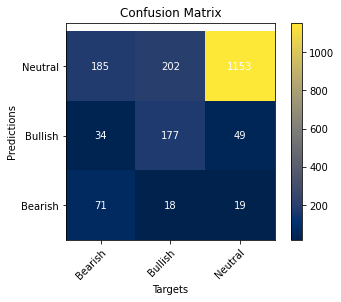

In [ ]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

### 4.3. Word Embeddings

In [ ]:
w2v = gensim.downloader.load('glove-twitter-100')

In [ ]:
word_set = set(w2v.index_to_key)
def get_w2v2(corpus):
    doc_vec = np.zeros((len(corpus), w2v.vector_size))
    for i, document in tqdm(enumerate(corpus)):
        word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
        doc_vec[i] = np.mean(word_vectors, axis=0) if word_vectors.any() else np.zeros(w2v.vector_size)
    return doc_vec

In [ ]:
def get_w2v(corpus):
    doc_vec = []
    for document in tqdm(corpus):
        sentence_vector = 0
        count = 0
        for word in document.split():
            if word in w2v.index_to_key:
                count+=1
                #add each word vector to the sentence_vector list. This list will have all the word vectors for each sentence.
                sentence_vector = np.add(sentence_vector, w2v.word_vec(word))
        
        if count != 0:
            #Extract an average vector for each sentence (this will be our input)
            avg_vector=sentence_vector/count
        else:
            #If no words in the document are in the Word2Vec vocabulary, use a vector of zeros as the document vector
            avg_vector=np.zeros(w2v.vector_size)
        doc_vec.append(avg_vector)
    return doc_vec

In [ ]:
# Define feature
X = market_behavior_df_train["text"]

# Define target
y = np.array(market_behavior_df_train['label'])

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5

# Create the models
model_knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')
model_lr = LogisticRegression()
model_mlp = MLPClassifier(hidden_layer_sizes=(10, 10))
model_nb = GaussianNB()

# Create a KFold object to split the data into folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a list for each model's score
score_knn_list = []
score_lr_list = []
score_mlp_list = []
score_nb_list = []

# Initialize counter variable
fold_num = 0

# Iterate over the folds
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Preprocess the training data
    X_train_clean = clean(X_train, lemmatize = True, stemmer = False)

    # Preprocess the validation data using the same steps as the training data
    X_val_clean = clean(X_val, lemmatize = True, stemmer = False)

    # Vectorize both training and validation data using the vocabulary learned from the training set
    X_train_vectorize = get_w2v2(X_train_clean)
    X_val_vectorize = get_w2v2(X_val_clean)  

    # Fit the KNN model using the training data
    model_knn.fit(X_train_vectorize, y_train)

    # Evaluate the KNN model using the validation data
    score_knn = model_knn.score(X_val_vectorize, y_val)
    score_knn_array = np.array(score_knn).reshape(1,)

    # Fit the LR model using the training data
    model_lr.fit(X_train_vectorize, y_train)

    # Evaluate the LR model using the validation data
    score_lr = model_lr.score(X_val_vectorize, y_val)
    score_lr_array = np.array(score_lr).reshape(1,)

    # Fit the MLP model using the training data
    model_mlp.fit(X_train_vectorize, y_train)

    # Evaluate the MLP model using the validation data
    score_mlp = model_mlp.score(X_val_vectorize, y_val)
    score_mlp_array = np.array(score_mlp).reshape(1,)

    # Fit the NB model using the training data
    model_nb.fit(X_train_vectorize, y_train)

    # Evaluate the NB model using the validation data
    score_nb = model_nb.score(X_val_vectorize, y_val)
    score_nb_array = np.array(score_nb).reshape(1,)

    fold_num += 1

    # Print the scores for this fold
    print(f"\n Fold {fold_num} - KNN Score: {score_knn}, LR Score: {score_lr}, MLP Score: {score_mlp}, NP Score: {score_nb}")

    score_knn_list.append(score_knn_array)
    score_lr_list.append(score_lr_array)
    score_mlp_list.append(score_mlp_array)
    score_nb_list.append(score_nb_array)

100%|██████████| 1909/1909 [00:01<00:00, 1180.41it/s]
0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
7634it [00:00, 19644.27it/s]
1909it [00:00, 19595.33it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio


 Fold 1 - KNN Score: 0.7108433734939759, LR Score: 0.6946045049764275, MLP Score: 0.6872708224201153, NP Score: 0.6165531691985333


100%|██████████| 1909/1909 [00:01<00:00, 1174.40it/s]
0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
7634it [00:00, 19445.79it/s]
1909it [00:00, 20982.35it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio


 Fold 2 - KNN Score: 0.7255107386066003, LR Score: 0.6830801466736511, MLP Score: 0.6872708224201153, NP Score: 0.6385542168674698


100%|██████████| 1909/1909 [00:01<00:00, 1195.58it/s]
0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
7634it [00:00, 20112.75it/s]
1909it [00:00, 20759.95it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio


 Fold 3 - KNN Score: 0.7249869041382923, LR Score: 0.7008905185961236, MLP Score: 0.7087480356207438, NP Score: 0.6280775275013096


100%|██████████| 1908/1908 [00:01<00:00, 1221.88it/s]
0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
7635it [00:00, 20165.95it/s]
1908it [00:00, 21335.16it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio


 Fold 4 - KNN Score: 0.7033542976939203, LR Score: 0.6860587002096437, MLP Score: 0.6645702306079665, NP Score: 0.6111111111111112


100%|██████████| 1908/1908 [00:01<00:00, 1216.82it/s]
0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
7635it [00:00, 20674.48it/s]
1908it [00:00, 21363.63it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Fold 5 - KNN Score: 0.7033542976939203, LR Score: 0.6650943396226415, MLP Score: 0.6907756813417191, NP Score: 0.6137316561844863


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Calculate the mean scores for each model
mean_score_knn_WE = np.mean(np.concatenate(score_knn_list))
mean_score_lr_WE = np.mean(np.concatenate(score_lr_list))
mean_score_mlp_WE = np.mean(np.concatenate(score_mlp_list))
mean_score_nb_WE = np.mean(np.concatenate(score_nb_list))

In [ ]:
# Print the mean scores for each model
print(f"Mean KNN Score: {mean_score_knn_WE}")
print(f"Mean LR Score: {mean_score_lr_WE}")
print(f"Mean MLP Score: {mean_score_mlp_WE}")
print(f"Mean NB Score: {mean_score_nb_WE}")

# Determine the best model based on the mean score
best_model_WE = max(mean_score_knn_WE, mean_score_lr_WE, mean_score_mlp_WE, mean_score_nb_WE)
if best_model_WE == mean_score_knn_WE:
    best_model_WE = model_knn
elif best_model_WE == mean_score_lr_WE:
    best_model_WE = model_lr
elif best_model_WE == mean_score_mlp_WE:
    best_model_WE = model_mlp
else:
    best_model_WE = model_nb

# Print the mean scores for each model
print(f"The best model is: {type(best_model_WE).__name__}")

Mean KNN Score: 0.7136099223253417
Mean LR Score: 0.6859456420156975
Mean MLP Score: 0.687727118482132
Mean NB Score: 0.6216055361725821
The best model is: KNeighborsClassifier


In [ ]:
model_knn_WE = model_knn

In [ ]:
# Predict the scores on the validation dataset
y_pred = best_model_WE.predict(X_val_vectorize)

In [ ]:
# Evaluate word embeddings
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred, y_val, target_names = labels.keys())) #evaluate the predicted scores obtain with the scores from the validation dataset

              precision    recall  f1-score   support

     Bearish       0.28      0.48      0.35       167
     Bullish       0.45      0.54      0.49       333
     Neutral       0.89      0.77      0.82      1408

    accuracy                           0.70      1908
   macro avg       0.54      0.60      0.55      1908
weighted avg       0.76      0.70      0.72      1908



In [ ]:
confusion_matrix(y_pred, y_val)

array([[  80,   42,   45],
       [  61,  179,   93],
       [ 149,  176, 1083]])

<ipython-input-106-3dffcdc7d557>:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


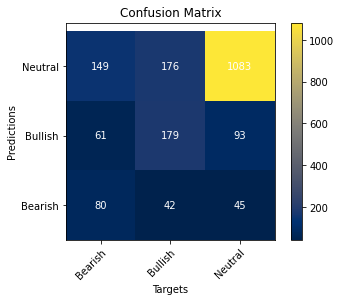

In [ ]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

#### 4.2.7. LSTM

In [5]:
w2v = gensim.downloader.load('glove-twitter-100')
emb_size = 100

In [6]:
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [55]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Preprocess the training data
X_train_clean = clean(X_train, lemmatize = True, stemmer = False)

# Preprocess the validation data using the same steps as the training data
X_val_clean = clean(X_val, lemmatize = True, stemmer = False)

100%|██████████| 1909/1909 [00:00<00:00, 3188.76it/s]


In [58]:
X_train_vec = corpus2vec(X_train_clean)
X_val_vec = corpus2vec(X_val_clean)

100%|██████████| 1909/1909 [00:09<00:00, 193.53it/s]


In [59]:
import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [60]:
#get list with lenghts of sentences
train_len = []
for i in X_train_vec:
    train_len.append(len(i))

In [61]:
#make all sentences the same size - model input must be of the same size
X_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_vec, padding="post", dtype='float64')

In [62]:
X = tf.convert_to_tensor(X_pad, dtype='float32')

In [63]:
#Most turn output into one hot encoded matrix
y = tf.one_hot(y_train, depth=3)

In [64]:
#make the model start with same weights
tf.random.set_seed(221)
#import packages
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, Masking, Dropout
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(max(train_len), emb_size))
 
'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=32))(mask)

'''activation layer'''
dropout = Dropout(0.5)(lstm) # Add dropout to prevent overfitting
act = Dense(3, activation='softmax')(dropout)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 100)]         0         
                                                                 
 masking_2 (Masking)         (None, 20, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 34,243
Trainable params: 34,243
Non-trainable params: 0
_______________________________________________________

In [66]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=2, mode='min', verbose=1)

history = model.fit(X, y, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
239/239 [==============================] - 17s 70ms/step - loss: 0.8353 - accuracy: 0.6472
Epoch 2/10
239/239 [==============================] - 17s 71ms/step - loss: 0.7406 - accuracy: 0.6941
Epoch 3/10
239/239 [==============================] - 17s 70ms/step - loss: 0.7061 - accuracy: 0.7062
Epoch 4/10
239/239 [==============================] - 18s 75ms/step - loss: 0.6710 - accuracy: 0.7258
Epoch 5/10
239/239 [==============================] - 17s 71ms/step - loss: 0.6528 - accuracy: 0.7354
Epoch 6/10
239/239 [==============================] - 17s 71ms/step - loss: 0.6156 - accuracy: 0.7548
Epoch 7/10
239/239 [==============================] - 17s 69ms/step - loss: 0.5890 - accuracy: 0.7692
Epoch 8/10
239/239 [==============================] - 17s 69ms/step - loss: 0.5699 - accuracy: 0.7764
Epoch 9/10
239/239 [==============================] - 17s 70ms/step - loss: 0.5450 - accuracy: 0.7833
Epoch 10/10
239/239 [==============================] - 17s 70ms/step - loss: 0.518

In [67]:
X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_vec, padding="post", dtype='float64')
X_val = tf.convert_to_tensor(X_val_pad, dtype='float32')

In [71]:
pred_y = model.predict(X_val)
y_pred = []
for doc in pred_y:
    y_pred.append(np.argmax(doc, axis=None, out=None))

lstm_score = accuracy_score(y_val, y_pred)
print(lstm_score)
print(classification_report(y_val, y_pred, target_names = labels.keys()))

60/60 [==============================] - 1s 24ms/step
0.7427972760607648
              precision    recall  f1-score   support

     Bearish       0.56      0.37      0.44       285
     Bullish       0.64      0.44      0.52       391
     Neutral       0.79      0.93      0.85      1233

    accuracy                           0.74      1909
   macro avg       0.66      0.58      0.60      1909
weighted avg       0.72      0.74      0.72      1909



/var/folders/3w/sskgxwn55ts3qf_m36f4w5mm0000gn/T/ipykernel_56787/1314786959.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


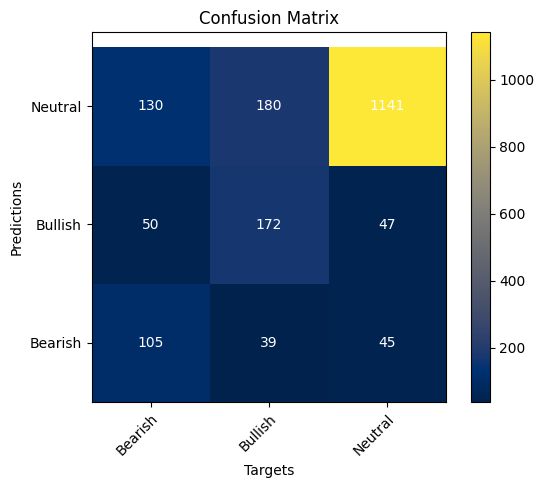

In [72]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())

## Choice of the model

In [70]:
# Assess of the best model
best_scores = {"BoW KNN": mean_score_knn_BoW, "BoW LR": mean_score_lr_BoW, "BoW MLP": mean_score_mlp_BoW, "BoW NB": mean_score_nb_BoW,
               "TF-IDF KNN": mean_score_knn_TF_IDF, "TF-IDF LR": mean_score_lr_TF_IDF, "TF-IDF MLP": mean_score_mlp_TF_IDF, "TF-IDF NB": mean_score_nb_TF_IDF,
               "WE KNN": mean_score_knn_WE, "WE LR": mean_score_lr_WE, "WE MLP": mean_score_mlp_WE, "WE NB": mean_score_nb_WE
               }

best_model = None
for model, score in best_scores.items():
    if best_model is None or score > best_scores[best_model]:
        best_model = model
        
print("The best model is:", best_model)

NameError: name 'mean_score_knn_TF_IDF' is not defined

Based on the previous model evaluation, it was determined that the BoW LR model performed the best. However, when it comes to text mining and sentiment analysis, the most crucial metrics will depend on the specific task and analysis objectives.

Our analysis includes several measures such as accuracy, precision, recall, F1 score, and confusion matrix. After evaluating these measures, we have concluded that the Word Embeddings vectorization technique outperformed the other methods studied in this analysis. Specifically, we have chosen the KNN model.

Therefore, we have decided to choose the KNN model over the original BoW LR model.

In [ ]:
# Specify the path to the pickled model file on your Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Text Mining/Projeto/model.pickle'

# Open the file in binary write mode and dump the pickled model
with open(path, 'wb') as f:
    pickle.dump(model_knn_WE, f)

## Deployment

In [ ]:
# Load the pickled model file
with open('/content/drive/MyDrive/Colab Notebooks/Text Mining/Projeto/model.pickle', 'rb') as file:
    model_knn_WE = pickle.load(file)
file.close()

In [ ]:
# Create a data preparation dataset from the original dataset
df = market_behavior_df_test.copy(deep=True)

In [ ]:
# Define feature
X = df["text"]

In [ ]:
# Preprocess the validation data using the same steps as the training data
X_clean = clean(X, lemmatize = True, stemmer = False)

100%|██████████| 2388/2388 [00:02<00:00, 1156.97it/s]


In [ ]:
# Vectorize both training and validation data using the vocabulary learned from the training set
X_vectorize = get_w2v2(X_clean)

0it [00:00, ?it/s]<ipython-input-130-39a7fdcf4c40>:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  word_vectors = np.array([w2v.word_vec(word) for word in document.split() if word in word_set])
2388it [00:00, 18082.39it/s]


In [ ]:
# Run the prediction
y_pred = model_knn_WE.predict(X_vectorize)

In [ ]:
# Add predictions to new column in dataframe
market_behavior_df_test['predictions'] = y_pred

In [ ]:
# Export dataframe to Excel
market_behavior_df_test.to_excel('predictions.xlsx', index=False)

In [ ]:
# Download the CSV file to your local machine
files.download('predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>